<a href="https://colab.research.google.com/github/anacgfp/modelagem-analitica/blob/main/Modelagem_Analitica_Aula2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Leitura dos arquivos de dados; 
2. Análise exploratória dos dados (gráfico da série, análise dos dados a nível diário, semanal, mensal, histograma, densidade de probabilidade, características estatísticas, box-plot, médias móveis); 
3. Transformação ou não das séries: trabalhar com a série original e com a transformada. Exemplo: Ln e Box-Cox; 
4. Decomposição da série (Aditivo e Multiplicativo); 
4.Teste Dickey Fuller aumentado, KPSS, PP.

#Leitura dos Dados


In [ ]:
#Importações
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt


  
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Leitura dos arquivos de Dados

def read_data(local_serie, parse_serie):
  serie = pd.read_csv(local_serie, parse_dates=[parse_serie[0]])
  serie = serie[parse_serie]
  serie = serie.rename(columns={parse_serie[0]: 'Data', parse_serie[1]: 'Potencia(MW)'})
  serie.index = serie['Data']
  serie = serie.drop(['Data'], axis=1)
  return serie

#Análise Exploratória dos Dados


**Histograma, densidade de probabilidade, características estatísticas**

In [ ]:
#Função que retorna as características estatísticas a partir de uma série s.
def caracteristicas_estatisticas(s):
  maximo1 = max(s)
  minimo1 = min(s)
  media = s.mean()
  mediana = s.median()
  q1, q2, q3 = s.quantile(q=0.25), s.quantile(q=0.5), s.quantile(q=0.75)
  moda = s.mode()
  amplitude = maximo1 - minimo1
  variancia = s.var()
  desvio_padrao = s.std()
  print('Máximo: ', maximo1, '\n', 'Minímo: ', minimo1, '\n', 'Média: ', media, 
        '\n', 'Mediana: ',mediana, '\n', 'Q1: ', q1, '\n', 'Q2: ', q2,  
        '\n', 'Q3: ', q3, '\n', 'Moda: ', moda[0], '\n', 'Amplitude: ', amplitude, 
        '\n', 'Variância: ', variancia, '\n', 'Desvio Padrão: ', desvio_padrao)

#Função que plota o histograma e a densidade de probabilidades a partir de uma serie
def plot_density_histogram(s):
  sns.distplot(s, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3})

**Análise dos dados a nível diário, semanal, mensal**

In [ ]:
def plot_resample(serie, periodo='D', metric='sum'):
  if metric == 'sum':
    serie_resample = serie.resample(periodo).sum()
  elif metric == 'mean':
    serie_resample = serie.resample(periodo).mean()
  return serie_resample

**Box-Plot** 

In [ ]:
def box_plot(serie, freq, title):
  # Considerando que a série temporal de entrada tem as datas como index:
  serie_boxplot = serie.copy(deep=True)
  # Prepare data
  if freq == 'year':
    serie_boxplot[freq] = [d.year for d in serie_boxplot.index]
    years = serie_boxplot[freq].unique()
  elif freq == 'month':
    serie_boxplot[freq] = [d.strftime('%b') for d in serie_boxplot.index]
  elif freq == 'weeks':
    print(freq)
    serie_boxplot[freq] = [d.strftime('%W') for d in serie_boxplot.index]
  elif freq == 'daily':
    serie_boxplot[freq] = [d.strftime('%D') for d in serie_boxplot.index]  

  # Draw Plot
  
  figure = plt.figure(figsize=(21,7), dpi= 80)
  sns.boxplot(x=freq, y='Potencia(MW)', data=serie_boxplot)
  # Set Title
  plt.title(title)

  plt.show()

# box_plot(serie_1_semanal, 'daily', 'Month wise box plot')


#**Médias Móveis**

Referências

https://towardsdatascience.com/moving-averages-in-python-16170e20f6c

In [ ]:
# simple moving average (SMA)
def moving_avg(serie, janela1, janela2, freq):
  serie_moving_avg = serie.copy(deep=True)
  serie_moving_avg = plot_resample(serie_moving_avg, periodo=freq, metric='mean')
  moving_avg_col = freq + (janela1)
  serie_moving_avg[moving_avg_col] = 0
  serie_moving_avg[moving_avg_col] = serie_moving_avg['Potencia(MW)'].rolling(int(janela1), min_periods=1).mean()
  moving_avg_col = freq + (janela2)
  serie_moving_avg[moving_avg_col] = serie_moving_avg['Potencia(MW)'].rolling(int(janela2), min_periods=1).mean()

  # colors for the line plot
  colors = ['green', 'red', 'purple']

  # line plot - the yearly average air temperature in Barcelona
  serie_moving_avg.plot(color=colors, linewidth=3, figsize=(12,6))

  # modify ticks size
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.legend(labels =['Média', freq + (janela1) + ' SMA', freq + (janela2)+ ' SMA'], fontsize=14)

  # title and labels
  plt.title('Médias móveis simples - Potência', fontsize=20)
  plt.xlabel(freq, fontsize=16)

#Transformação das séries: Box Cox e Ln

**Box Cox**

In [ ]:
def boxcox_transf(serie):
  serie_boxplot = serie.copy(deep=True)
  original_data = serie_boxplot['Potencia(MW)']  
  fitted_data, fitted_lambda = stats.boxcox(original_data) 
  
  fig, ax = plt.subplots(1, 2) 
  
  #plota os dados originais
  sns.distplot(original_data, hist = False, kde = True, 
              kde_kws = {'shade': True, 'linewidth': 2},  
              label = "Non-Normal", color ="green", ax = ax[0]) 
  ax[0].set_title('Dados originais', fontsize=12)
  sns.distplot(fitted_data, hist = False, kde = True, 
              kde_kws = {'shade': True, 'linewidth': 2},  
              label = "Normal", color ="green", ax = ax[1])
  ax[1].set_title('Dados Transformados', fontsize=12)

    
  # adding legends to the subplots 
  plt.legend(loc = "upper right") 
    
  # rescaling the subplots 
  fig.set_figheight(5) 
  fig.set_figwidth(21)
  print(f"Lambda da transformação: {fitted_lambda}")

**Ln**


In [ ]:
def ln_transformation(serie):
  ts_log = np.log(serie)
  ts_log.head()
  plt.plot(ts_log)

#Decomposição da série (Aditivo e Multiplicativo)


In [ ]:
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 21, 6

def decompose(serie, _model):
  result = seasonal_decompose(serie, model=_model)
  result.plot()

#Teste Dickey Fuller aumentado, KPSS, PP.

In [ ]:
#Teste Dickey Fuller aumentado, KPSS, PP.

from statsmodels.tsa.stattools import adfuller, kpss
def adf_test(serie):
  result = adfuller(serie['Potencia(MW)'].values, autolag='AIC')
  print(f'ADF Statistic: {result[0]}')
  print(f'p-value: {result[1]}')
  for key, value in result[4].items():
    print('Critical Values:')
    print(f'   {key}, {value}')

def kpss_test(serie):
# KPSS Test
  result = kpss(serie['Potencia(MW)'].values, regression='c')
  print('\nKPSS Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  for key, value in result[3].items():
    print('Critical Values:')
    print(f'   {key}, {value}')

#Modelo de Persistência

- One step ahead

- multi step ahead 

In [ ]:
#One Step Ahead
def persistence_model(serie):
  # train, test = train_test_split(serie, test_size=0.25)
  train, test = np.array_split(serie, 2)[0], np.array_split(serie, 2)[1]

  # Prepare data
  test = test['Potencia(MW)'].values
  train = [x for x in train.values]

  # Walk-forward validation
  predictions = list()
  for i in range(len(test)):
    yhat = train[-1]

    # Store forecast in list of predictions
    predictions.append(yhat)

    # Add actual observation to train for the next loop
    obs = test[i]
    train.append(obs)
    # print('>Predicted=%.3f, Expected=%.3f' % (float(yhat), float(obs)))
  # Report performance
  rmse = sqrt(mean_squared_error(test, predictions))
  print('RMSE: %.3f' % rmse)
  # Plot predicted vs expected values
  plt.plot(test, color='blue')
  # plt.plot(predictions, color='red')
  plt.show()


In [ ]:
# Evaluate a multi-step persistence model

# Plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, test):
	# Plot the entire dataset in blue
	plt.plot(series)
	# Plot the forecasts in red
	for i in range(len(forecasts)):
        # Start offset for x-axis
		off_s = len(series) - len(test) + i - 1
        # End offset for x-axis
		off_e = off_s + len(forecasts[i]) + 1
        # Indexes of x-axis for multi-step forecasts
		xaxis = [x for x in range(off_s, off_e)]
        # Values of muti-step fotecasts
		yaxis = [series[off_s]] + forecasts[i]  
		plt.plot(xaxis, yaxis, color='red')
	# Show the final plot
	plt.show()           

# Evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_steps):
	error_over_time = [0]*n_steps
	x_axis = []
	for i in range(n_steps):
		# Picking the values from multi-step forecasts
		ypred_ts = [forecast[i] for forecast in forecasts]
		# Sliding window on test series
		ytrue_ts = test[i:len(ypred_ts)+i]
		error_over_time[i] = sqrt(mean_squared_error(ytrue_ts, ypred_ts))
		print('t+%d RMSE: %f' % ((i+1), error_over_time[i]))
	for i in range(n_steps):
		x_axis.append(i+1)
	plt.plot(x_axis, error_over_time)
	plt.title('Desempenho em relação ao número de passos')
	plt.show()

# Make a multi-step persistence forecast
def persistence(last_ob, n_steps):
	return [last_ob for i in range(n_steps)]

def persistence_model_multi(serie, number_step = 10):
  # Load data
  train, test = np.array_split(serie['Potencia(MW)'], 2)[0], np.array_split(serie['Potencia(MW)'], 2)[1]
  # Concatenate train/test series for plotting
  series = pd.concat([train, test], axis=0)

  # Prepare data
  test = test.values
  series = series.values
  train = [x for x in train]
  # Number of multi-step
  n_steps = number_step
  # Store multi-step forecasts
  forecasts = list()
  # Number of multi-step forecasts
  n_forecasts = len(test) - n_steps + 1
  # Walk-forward validation
  for i in range(n_forecasts):
    # Make a multi-step forecast
    last_ob = train[-1]
    yhat = persistence(last_ob, n_steps)
    # Store the multi-step forecast
    forecasts.append(yhat)
    # Add actual observation to train for the next loop
    obs = test[i]
    train.append(obs)

# Holtz winter

In [ ]:
def holtz_winter(serie):
  # Separando dados em treino e teste
  train= np.array_split(serie, 2)[0]
  test= np.array_split(serie, 2)[1]
  y_hat_avg = test.copy()

  # Realizando o treino e a previsão
  fit1 = ExponentialSmoothing(np.asarray(train['Potencia(MW)']) ,seasonal_periods=7 ,trend='add', seasonal='add').fit(smoothing_level=0.6)
  y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))

  # Gerando o Grafico
  plt.figure(figsize=(16,8))
  plt.plot( train['Potencia(MW)'], label='Train')
  plt.plot(test['Potencia(MW)'], label='Test')
  plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
  plt.legend(loc='best')
  plt.show()

  # Calculando o erro
  rms = sqrt(mean_squared_error(test['Potencia(MW)'], y_hat_avg.Holt_Winter))
  print(rms)

# Alisamento

In [ ]:
def simple_smoothing(serie):
  # Separando dados em treino e teste
  train= np.array_split(serie, 2)[0]
  test= np.array_split(serie, 2)[1]
  y_hat_avg = test.copy()

  # Realizando o treino e a previsão
  fit1 = SimpleExpSmoothing(np.asarray(train['Potencia(MW)'])).fit(smoothing_level=0.6)
  y_hat_avg['Simple_Exp_Smoothing'] = fit1.predict(len(test))
  # y_hat_avg['Simple_Exp_Smoothing'] = fit1.forecast(len(test))

  # Gerando o Grafico
  plt.figure(figsize=(16,8))
  plt.plot( train['Potencia(MW)'], label='Train')
  plt.plot(test['Potencia(MW)'], label='Test')
  plt.plot(y_hat_avg['Simple_Exp_Smoothing'], label='Simple_Exp_Smoothing')
  plt.legend(loc='best')
  plt.show()

  # Calculando o erro
  rms = sqrt(mean_squared_error(test['Potencia(MW)'], y_hat_avg.Simple_Exp_Smoothing))
  print(rms)

In [ ]:
simple_smoothing(_serie1)

holtz_winter(_serie1)

ValueError: ignored

# Arima

In [ ]:
import statsmodels.api as sm

def arima(serie):
  train= np.array_split(serie, 2)[0]
  test= np.array_split(serie, 2)[1]
  y_hat_avg = test.copy()
  fit1 = sm.tsa.statespace.SARIMAX(train['Potencia(MW)'], order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit()
  y_hat_avg['SARIMA'] = fit1.predict(dynamic=True)
  plt.figure(figsize=(16,8))
  plt.plot( train['Potencia(MW)'], label='Train')
  plt.plot(test['Potencia(MW)'], label='Test')
  plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
  plt.legend(loc='best')
  plt.show()
  rms = sqrt(mean_squared_error(test['Potencia(MW)'], y_hat_avg.SARIMA))
  print(rms)

# Série 1 - Dados diários

In [ ]:
#Leitura dos Dados
SERIE_DAILY = "/content/drive/MyDrive/Modelagem Analítica/daily.csv"
PARSE_DAILY = ['Data Escala de Tempo 1 DM Simp 4', 'Selecione Tipo de DM Simp 4']

serie_diaria = read_data(SERIE_DAILY, PARSE_DAILY)
_serie1 = serie_diaria

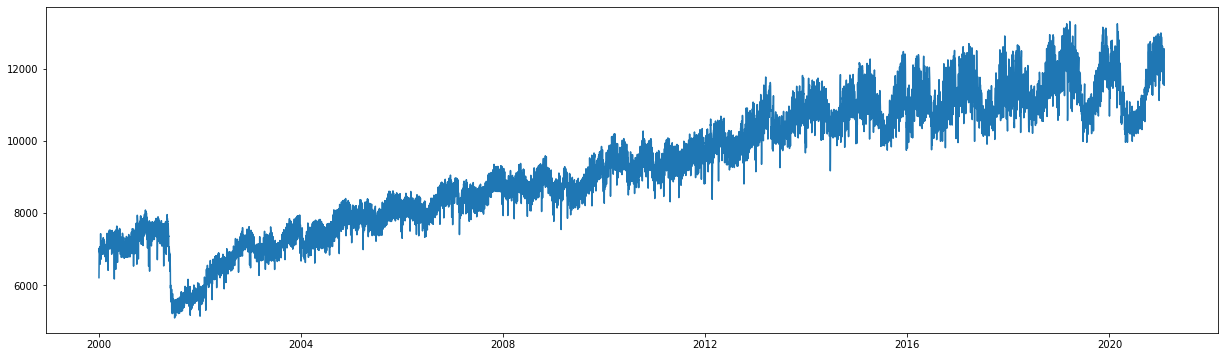

In [ ]:
#Gráfico da série diária

plt.plot(_serie1)

Máximo:  13306.963 
 Minímo:  5087.9 
 Média:  9393.276347487363 
 Mediana:  9324.78 
 Q1:  7976.7 
 Q2:  9324.78 
 Q3:  10914.15 
 Moda:  7160.0 
 Amplitude:  8219.063 
 Variância:  3292779.4518329985 
 Desvio Padrão:  1814.6017336685752


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


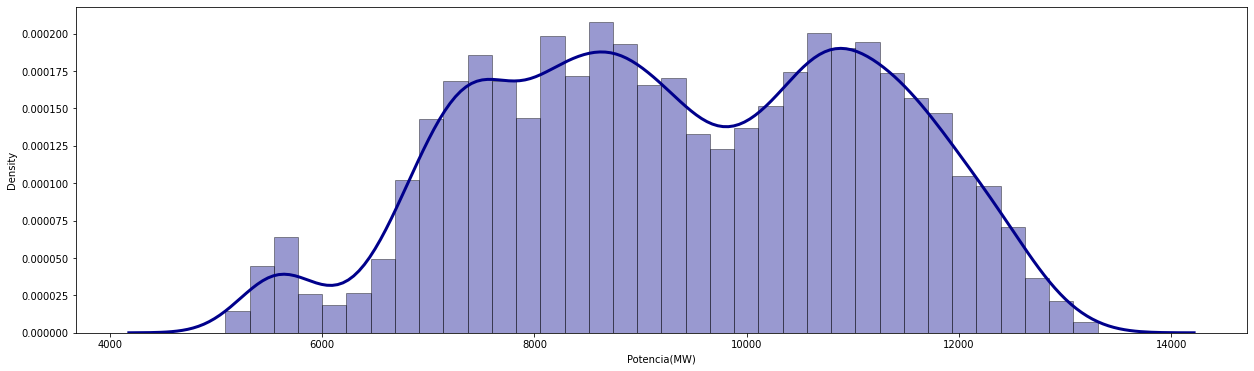

In [ ]:
#Análise descritiva

s = _serie1['Potencia(MW)']

caracteristicas_estatisticas(s)
plot_density_histogram(s)

weeks


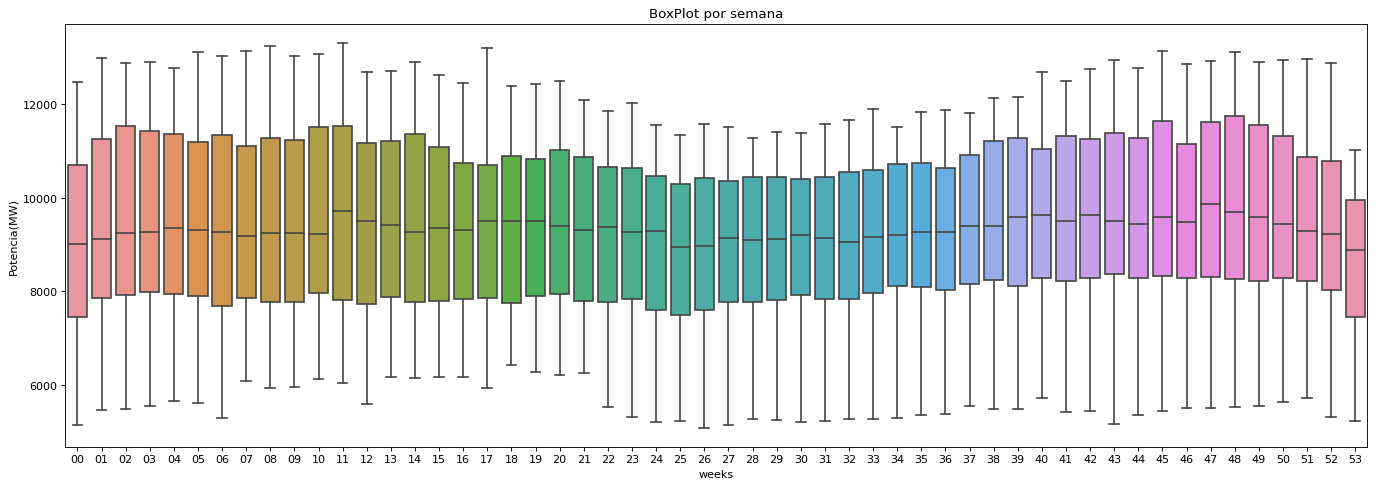

In [ ]:
# Boxplot

box_plot(_serie1, 'weeks', 'BoxPlot por semana')

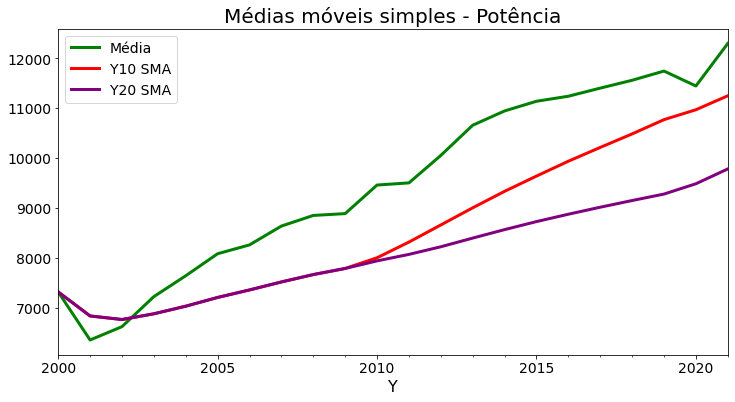

In [ ]:
moving_avg(_serie1, '10', '20', 'Y')

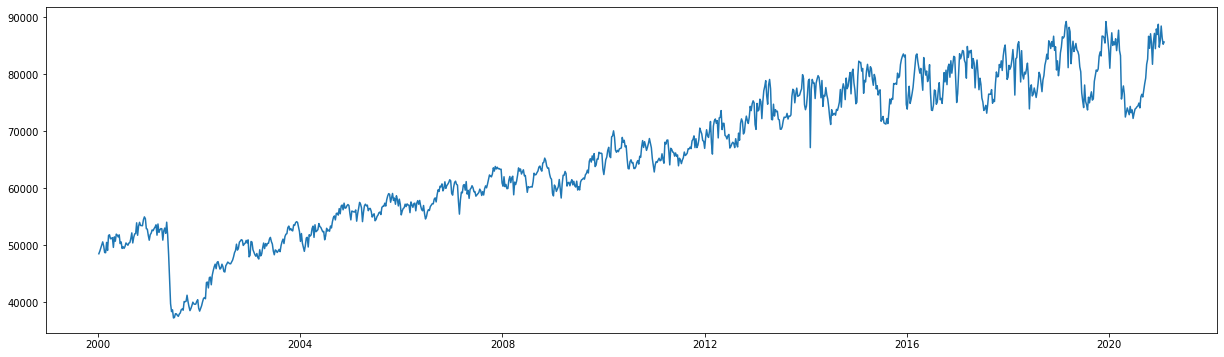

In [ ]:
# Mudando a frequencia pra semanal
serie_semanal = plot_resample(_serie1, 'W') #Semanal
plt.plot(serie_semanal[1:])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Lambda da transformação: 1.0952244035436294


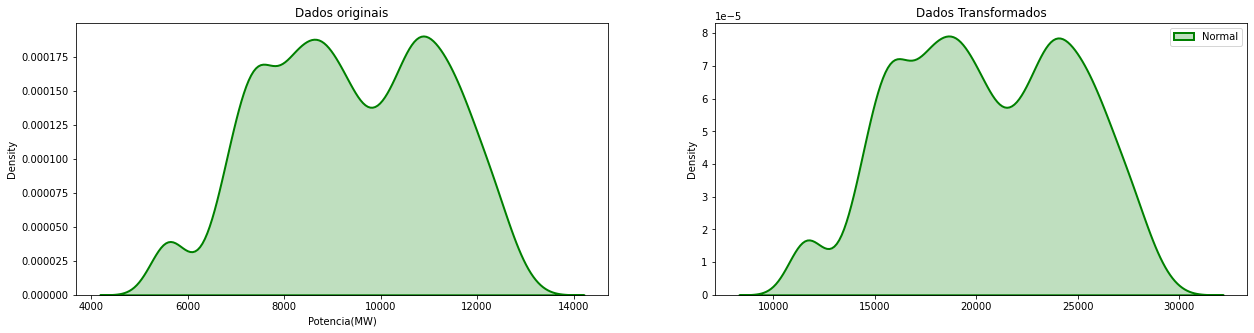

In [ ]:
#Plot do boxplot
boxcox_transf(_serie1)

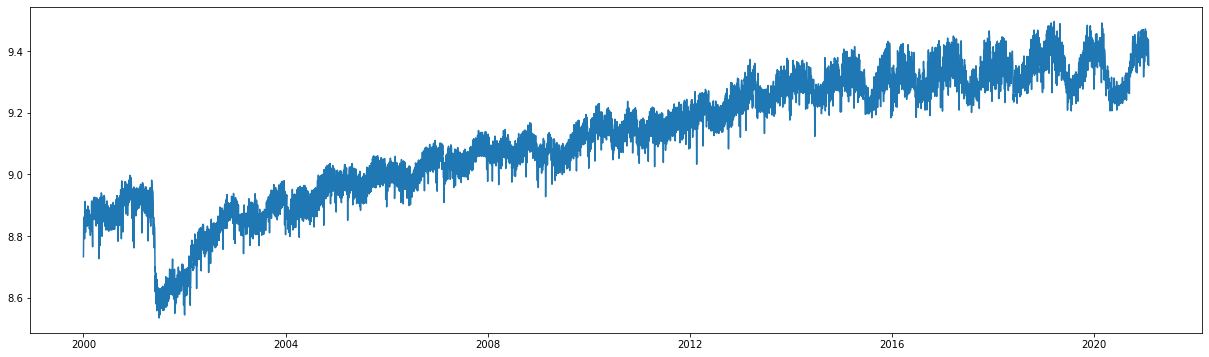

In [ ]:
#Plot da transformação logaritimica

ln_transformation(_serie1)

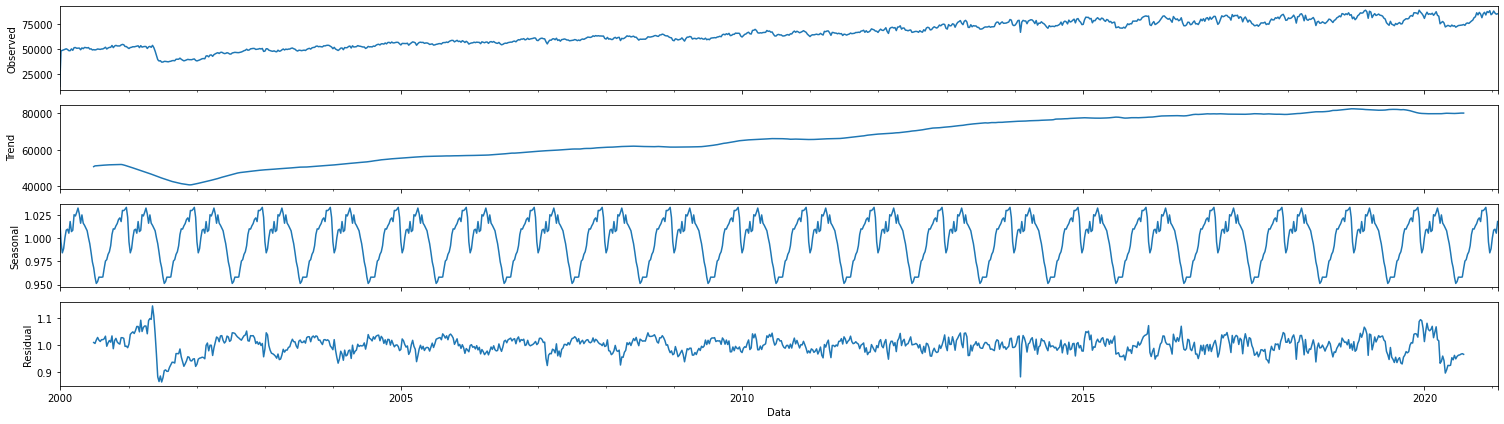

In [ ]:
#Decomoposição da serie
decompose(serie_semanal, 'multiplicative')

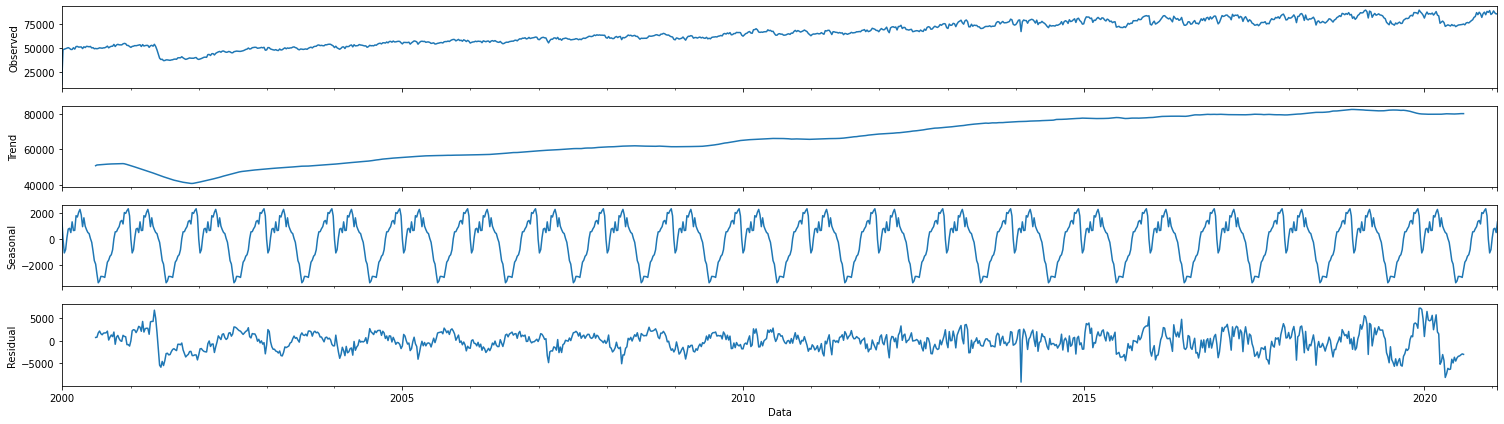

In [ ]:
#Decomoposição da serie
decompose(serie_semanal, 'additive')

In [ ]:
#Testes de estacionariedade
print(adf_test(_serie1))
print('\n--------------------------------------------------------')
print(kpss_test(_serie1)) # Caso maior que 0.05 rejeita a hipotese que os dados são estacionarios


ADF Statistic: -1.311066589917708
p-value: 0.6240942496353329
Critical Values:
   1%, -3.4312034235233315
Critical Values:
   5%, -2.8619171497798384
Critical Values:
   10%, -2.5669707523119336
None

--------------------------------------------------------

KPSS Statistic: 19.702133
p-value: 0.010000
Critical Values:
   10%, 0.347
Critical Values:
   5%, 0.463
Critical Values:
   2.5%, 0.574
Critical Values:
   1%, 0.739
None


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


RMSE: 468.296


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


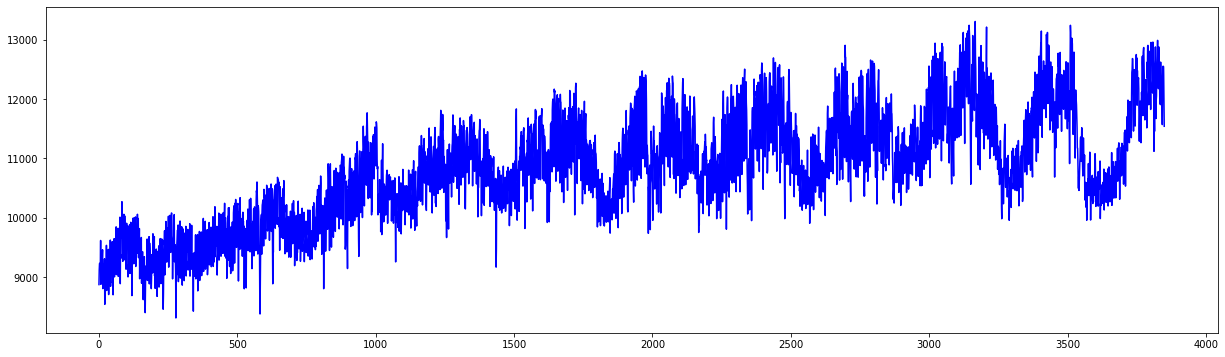

In [ ]:
#Modelo de persistencia

persistence_model(_serie1)

In [ ]:
# Modelo de persistencia multi

persistence_model_multi(_serie1, 100)

In [ ]:
simple_smoothing(_serie1)

TypeError: ignored

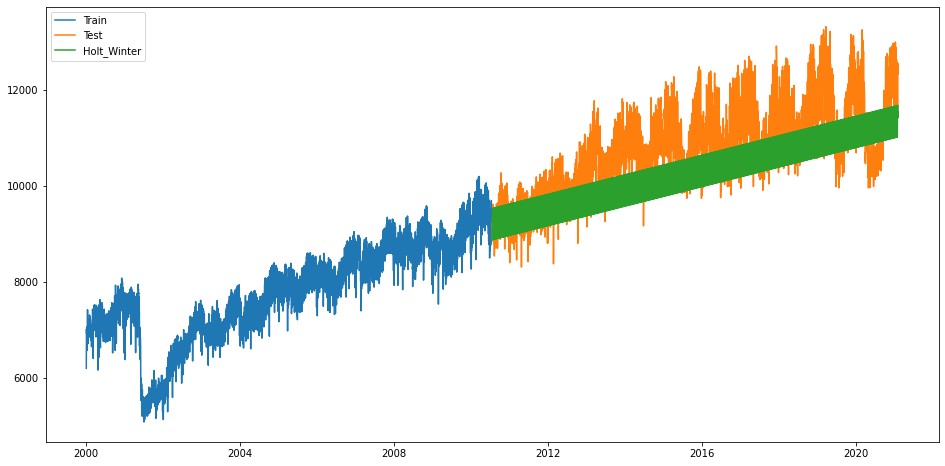

875.306999122447


In [ ]:
holtz_winter(_serie1)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


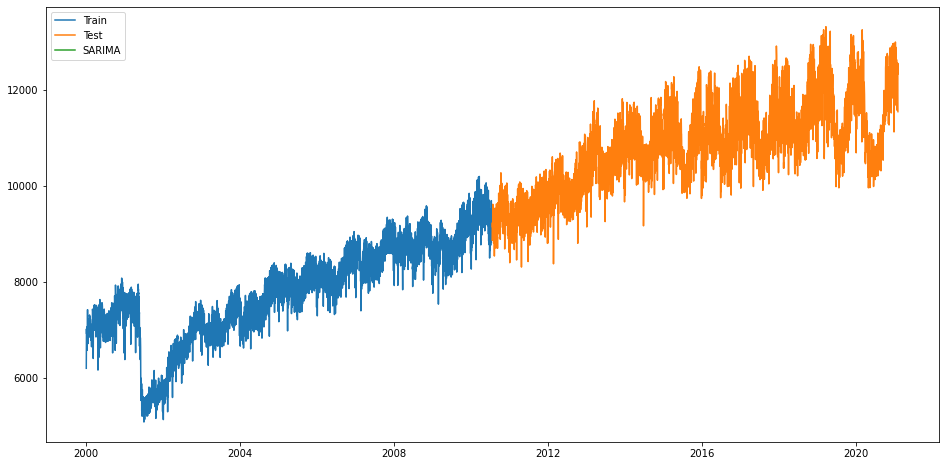

ValueError: ignored

In [ ]:
arima(_serie1)

# Série 2 - Dados por Hora

In [ ]:
#Leitura dos Dados
SERIE_HOURLY = "/content/drive/MyDrive/Modelagem Analítica/hourly.csv"
PARSE_HOURLY = ['Data Escala de Tempo 1 GE Simp 4', 'Selecione Tipo de GE Simp 4']

serie_hora = read_data(SERIE_HOURLY, PARSE_HOURLY)

# Redução da base de dados para simplificar compreensão dos graficos
# Utiilizando 10% da base de dados
serie_hora_completa = serie_hora
serie_hora = np.array_split(serie_hora_completa, 4)[0]

_serie2 = serie_hora

In [ ]:
#Gráfico da série por hora

plt.plot(_serie2)

In [ ]:
#Análise descritiva

s = _serie2['Potencia(MW)']

caracteristicas_estatisticas(s)
plot_density_histogram(s)

In [ ]:
# Boxplot
serie_boxplot = np.array_split(_serie2, 40)[0]
box_plot(serie_boxplot, 'daily', 'BoxPlot por mês')

In [ ]:
moving_avg(_serie2, '24', '168', 'H')

In [ ]:
serie_diaria = plot_resample(_serie2, 'D') #Diário

plt.plot(serie_diaria)
# decompose(serie_semanal, 'multiplicative')

In [ ]:
#Plot do boxcox
# Aqui deixamos a serie completa para melhoor visualização grafica

boxcox_transf(serie_hora_completa)

In [ ]:
#Plot da transformação logaritimica

# Do 1 em diante pois a posição zero tinha valor zero
ln_transformation(serie_hora[1:])

In [ ]:
#Decomposição da serie
decompose(serie_diaria, 'multiplicative')

In [ ]:
_serie1['Potencia(MW)']

a = np.array_split(serie_diaria, 10)
decompose(a[0], 'multiplicative')

In [ ]:
#Decomposição da serie
decompose(serie_diaria, 'additive')

In [ ]:
#Testes de estacionariedade
print(adf_test(_serie2))
print('\n--------------------------------------------------------')
print(kpss_test(_serie2)) # Caso maior que 0.05 rejeita a hipotese que os dados são estacionarios

In [ ]:
#Modelo de persistencia
persistence_model(_serie2)

In [ ]:
# Modelo de persistencia multi
number_step = 144
persistence_model_multi(_serie2, number_step)

In [ ]:
simple_smoothing(_serie2)

In [ ]:
holtz_winter(_serie2)

In [ ]:
arima(_serie2)